In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 10.2 MB/s 
     |████████████████████████████████| 182 kB 47.8 MB/s 
     |████████████████████████████████| 7.6 MB 19.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 34.5 MB/s 
     |████████████████████████████████| 212 kB 57.6 MB/s 
     |████████████████████████████████| 132 kB 45.2 MB/s 
     |████████████████████████████████| 127 kB 69.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 29.6 MB/s 


In [ ]:
#import libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from sklearn.utils import shuffle
from google.colab import drive
from tqdm import tqdm
import regex as re
import string
import nltk
import pickle
import datasets
from datasets import Dataset
import torch



import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, EncoderDecoderModel, PegasusForConditionalGeneration, PegasusTokenizer
from tqdm import tqdm_notebook as tqdm

from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from sklearn.utils import shuffle
from google.colab import drive
from tqdm import tqdm
import regex as re
import string
import nltk
import pickle
import datasets
from datasets import Dataset, DatasetDict


In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load dataset
df=pd.read_csv("/content/drive/MyDrive/NLP_Project/final_imdb_movies.csv")

In [ ]:
df.head()

,Name,link,summary,storyline
0,The Shawshank Redemption,/title/tt0111161/,Two imprisoned men bond over a number of years...,Chronicles the experiences of a formerly succe...
1,The Godfather,/title/tt0068646/,The aging patriarch of an organized crime dyna...,"The Godfather ""Don"" Vito Corleone is the head ..."
2,Pulp Fiction,/title/tt0110912/,"The lives of two mob hitmen, a boxer, a gangst...",Jules Winnfield (Samuel L. Jackson) and Vincen...
3,The Godfather Part II,/title/tt0071562/,The early life and career of Vito Corleone in ...,The continuing saga of the Corleone crime fami...
4,Inception,/title/tt1375666/,A thief who steals corporate secrets through t...,"Dom Cobb is a skilled thief, the absolute best..."


In [ ]:
print(df["link"].nunique(), df["link"].count())

786 787


In [ ]:
df['link'].value_counts()

/title/tt0406759/    2
/title/tt0111161/    1
/title/tt0278488/    1
/title/tt0089880/    1
/title/tt0070034/    1
                    ..
/title/tt0449467/    1
/title/tt1038988/    1
/title/tt0346491/    1
/title/tt0277371/    1
/title/tt1073105/    1
Name: link, Length: 786, dtype: int64

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
print(df["link"].nunique(), df["link"].count())

786 786


In [ ]:
punctuations = set(string.punctuation)

In [ ]:
# remove special characters, digits, html tags ans punctuations
def preprocess(text):
    text = text.lower() #converting capitals to lower case
    text = text.strip()
    text= re.sub(r'\—.*$', " ", text)
    text=re.sub(r'\([^)]*\)', '', text)
    text = re.sub("<.*?>", " ", text) #removing html tags
    text = re.sub(r'[^\w\s]',' ',text) #remove special characters
    text = re.sub(" \d+", " ",text) # removing digits
    text = re.sub("\n", "", text) #removing \n
    text = re.sub("\t", "", text) #removing \t
    text = ''.join(ch for ch in text if ch not in punctuations)
    return text

In [ ]:
df["summary"] = df["summary"].apply(preprocess)

In [ ]:
df["storyline"] = df["storyline"].apply(preprocess)

In [ ]:
#split data
train, validate, test = np.split(df.sample(frac=1, random_state=10), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
df["word_count_storyline"] = df['storyline'].apply(lambda x: len(str(x).split()))
df["word_count_summary"] = df['summary'].apply(lambda x: len(str(x).split()))

In [ ]:
df.head()

,Name,link,summary,storyline,word_count_storyline,word_count_summary
0,The Shawshank Redemption,/title/tt0111161/,two imprisoned men bond over a number of years...,chronicles the experiences of a formerly succe...,62,19
1,The Godfather,/title/tt0068646/,the aging patriarch of an organized crime dyna...,the godfather don vito corleone is the head ...,151,24
2,Pulp Fiction,/title/tt0110912/,the lives of two mob hitmen a boxer a gangst...,jules winnfield and vincent vega are two hit...,83,27
3,The Godfather Part II,/title/tt0071562/,the early life and career of vito corleone in ...,the continuing saga of the corleone crime fami...,46,29
4,Inception,/title/tt1375666/,a thief who steals corporate secrets through t...,dom cobb is a skilled thief the absolute best...,167,40


Data Distribution


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f189c501fa0>,
      dtype=object)

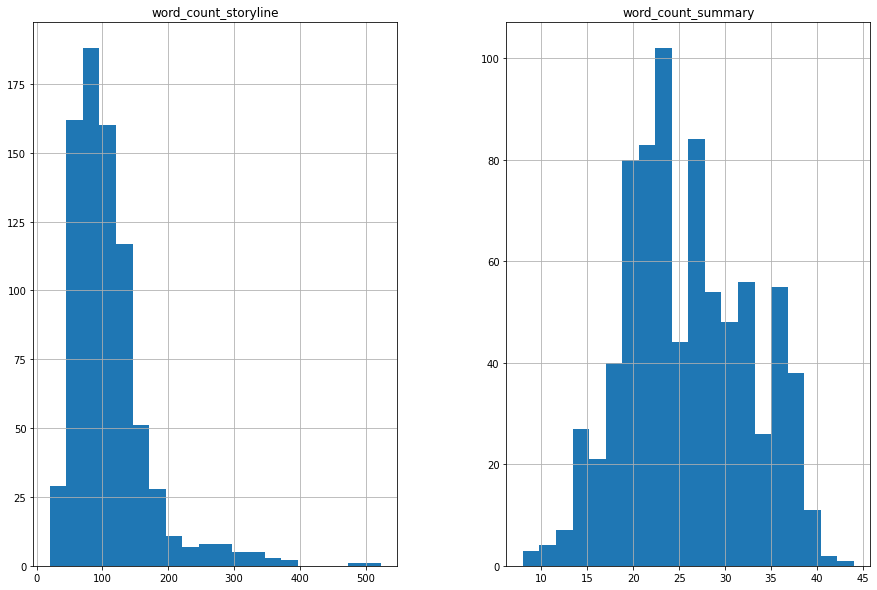

In [ ]:
df[["word_count_storyline", "word_count_summary"]].hist(bins=20, figsize=(15, 10))


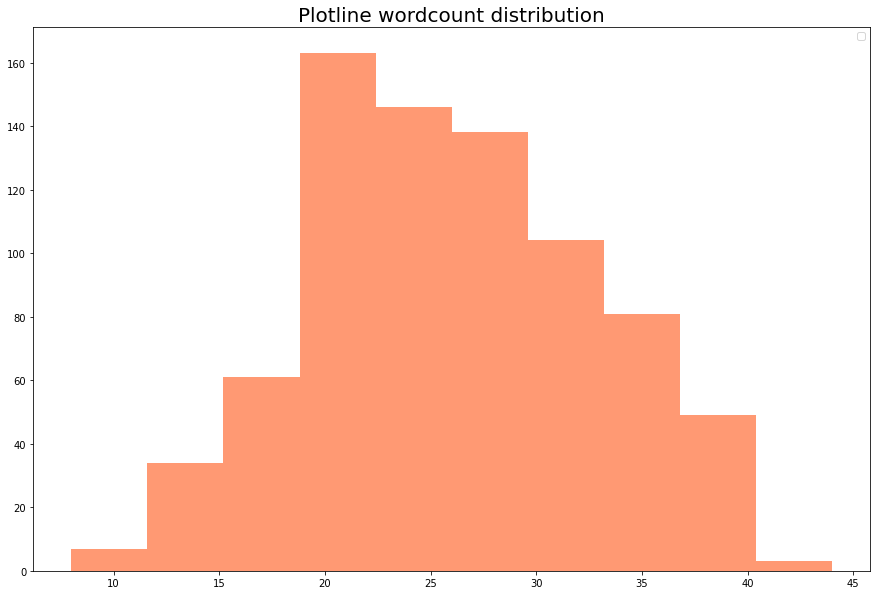

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
colors = ["#ff9973"] # whatever the colors may be but it should be different for each histogram.

ax.hist(df["word_count_summary"], color = colors[0])
ax.legend(loc = "best")
plt.title("Plotline wordcount distribution", size = 20)
plt.show()

# df[["word_count_storyline"]].hist(bins=20, figsize=(15, 10))


In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
colors = ["#00cfcc"] # whatever the colors may be but it should be different for each histogram.

ax.hist(df["word_count_storyline"], color = colors[0])
ax.legend(loc = "best")
plt.title("Storyline wordcount distribution", size = 20)
plt.show()


In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments

tokenizer_pretrained = PegasusTokenizer.from_pretrained('google/pegasus-xsum')


Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

# Create Enbeddings

In [ ]:
train_data = Dataset.from_pandas(train)
validate_data = Dataset.from_pandas(validate)
test_data = Dataset.from_pandas(test)

In [ ]:
class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        # self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    # def __len__(self):
    #     return len(self.labels['input_ids'])  # len(self.labels)

In [ ]:
#define class
class PegasusDatasetLabel(torch.utils.data.Dataset):
    def __init__(self, labels):
        # self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels['input_ids'])  # len(self.labels)

In [ ]:
# tokenizer
def prepare_data(model_name, 
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  print(model_name)
  tokenizer = PegasusTokenizer.from_pretrained(model_name)


  # prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    en_dataset_tokenized = PegasusDataset(encodings)
    de_datset_tokenized = PegasusDatasetLabel(decodings)
    return en_dataset_tokenized, de_datset_tokenized

  # train_dataset = tokenize_data(train_texts, train_labels)
  # val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset_ip, test_dataset_op = tokenize_data(test_texts, test_labels) if prepare_test else None

  return  test_dataset_ip, test_dataset_op, tokenizer

In [ ]:
train_storyline, train_summary = train_data['storyline'], train_data['summary']
val_storyline, val_summary = validate_data['storyline'], train_data['summary']
test_storyline, test_summary = test_data['storyline'], test_data['summary']
  

In [ ]:
#Frees up unused memory 
import gc
torch.cuda.empty_cache()
gc.collect()

68

In [ ]:
# use Pegasus Large model as base for fine-tuning
model_name = 'google/pegasus-xsum'
test_datatset_ip,test_dataset_op, tokenizer = prepare_data(model_name, test_storyline, test_summary)


google/pegasus-xsum


In [ ]:
test_datatset_ip[0]

{'input_ids': tensor([  277,  2190,   114,   439,  1580,   134, 29970,  6710,  2858,  1309,
          3018, 31272,  4429,  6033,  7323,   148,   114,  1133,  8443, 24693,
           113,   114,   439,  4897,   120,   138,   711,   115,   223, 21966,
           330,   500,   200,   120,   127,   115,   109,  1684, 31272,  8634,
           116,   169, 10099,  3834, 10865,   466,   122,   169,   594,  6662,
           111, 21452,  2829,   112,   858,   114,   750,  5068,  1729, 59225,
          3119, 53891,   466,   122,   114, 15493,  1729,   439,  4178,   114,
          1499,   111,   215,   228,  7929,   111,   500,   176,   200,   857,
         31272,   165,  5683,   244,   157,   858, 31272,   110,   116,  1133,
          8443, 24693,   472,   921,   173, 11259,   388,  7480, 31272,   169,
           594,   111, 59225,   355,   508,   112,   258,   109,  2756, 11259,
           111,   803,   183,   135,  1323,   269,   126,   117,   314,  1095,
             1,     0,     0,     0,   

In [ ]:
#load pretrained model
model = PegasusForConditionalGeneration.from_pretrained("/content/drive/MyDrive/results/checkpoint-1000/")

In [ ]:
from tqdm.notebook import tqdm as tqdm
import time

In [ ]:
# get predictions
def predict_summary(test_datatset):
  start_time = time.time()
  predictions = []
  for i, test_data in  tqdm(enumerate(test_datatset)):
    # print(test_data)
    summary_ = model.generate(inputs=test_data['input_ids'].unsqueeze(0), attention_mask=test_data['attention_mask'].unsqueeze(0))
    pred = tokenizer.decode(summary_[0])    
    predictions.append(pred)
  return predictions

In [ ]:
predictions = predict_summary(test_datatset_ip)

0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
#save predictions to csv
dict_predicted = {'predicted': predictions, 'actual': test_summary}
df_predicted = pd.DataFrame.from_dict(dict_predicted)
df_predicted.to_csv('/content/drive/MyDrive/results/pegasus_predictions_checkpoint_1000.csv')  

In [ ]:
df_predicted.head(5)

,predicted,actual
0,<pad>while watching a car race at mckinley spe...,a horrifying premonition saves a young man and...
1,<pad>fbi profilers strahm and perez are sent t...,despite jigsaw s death and in order to save t...
2,<pad>a team of scientists and engineers must f...,after discovering that an asteroid the size of...
3,<pad>when a green ogre discovers his swamp has...,a mean lord exiles fairytale creatures to the ...
4,<pad>a small town is invaded by minature green...,a young man inadvertently breaks three importa...


In [ ]:
!pip install sumeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 118 kB 60.9 MB/s 
  Created wheel for sumeval: filename=sumeval-0.2.2-py3-none-any.whl size=54549 sha256=f3d8043b900e46dfe827b5f8ad2aec3a0952b10c8c9e42cdcdff68f4da65ff20
  Stored in directory: /root/.cache/pip/wheels/6a/e8/4e/76111a2e023408af67380b35a6a910763432fc0afe20348f17
Successfully built sumeval


In [ ]:
#evaluate results - rouge
from sumeval.metrics.rouge import RougeCalculator
import numpy as np


rouge = RougeCalculator(stopwords=True, lang="en")
Rouge_1 = []
Rouge_2 = []
Rouge_l = []

for i in range(len(predictions)):

    rouge_1 = rouge.rouge_n(
    summary=predictions[i],
    references=test_summary[i],
    n=1)
    
    Rouge_1.append(rouge_1)
 
 
 ## rogue_2

    rouge_2 = rouge.rouge_n(
     summary=predictions[i],
     references=test_summary[i],
    n=2)
    Rouge_2.append(rouge_2)
 ## rogue_l

    rouge_l = rouge.rouge_l(
     summary=predictions[i],
     references=test_summary[i])
    Rouge_l.append(rouge_l)

print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}".format(np.round(sum(Rouge_1)/len(Rouge_1),3),
 np.round(sum(Rouge_2)/len(Rouge_2),3),
 np.round(sum(Rouge_l)/len(Rouge_l),3)
))


ROUGE-1: 0.167, ROUGE-2: 0.052, ROUGE-L: 0.152
